# Fourier-Transformation und Filter

Um das Verständnis für die Fourier-Transformation und ihre Möglichkeiten zu vertiefen, werden wir hier einige Audiosignale filtern. Zuerst wirst du ein Audiosignal mit einem hohen Brummton erzeugen und dann den Brummton mit Hilfe der Fourier-Transformation entfernen.

## Signal erstellen

Sinuswellen werden manchmal als reine Töne bezeichnet, weil sie eine einzige Frequenz darstellen. Hier werden wir werden Sinuswellen verwenden, um das Audio zu erzeugen, da diese deutliche Spitzen im resultierenden Frequenzspektrum bilden.
Ein weiterer Vorteil von Sinuswellen ist, dass sie mit 'NumPy' einfach zu erzeugen sind. 

Als erstes laden wir einige Libraries und Einstellung:

In [1]:
# Noise Tone
#Benötigte Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# MatplotLib Settings:
plt.style.use('default') # Matplotlib Style wählen
plt.rcParams['font.size'] = 10; # Schriftgröße

Als Nächstes definieren wir eine Funktion zur Erzeugung einer Sinuswelle, da Sie diese später mehrfach verwenden werden. Die Funktion nimmt eine Frequenz, freq, und gibt dann die x- und y-Werte zurück, die wir für die Darstellung der Welle verwenden werden.

In [2]:
def generate_sine_wave(freq, sample_rate, duration):
    t = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = t * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return t, y

* `SAMPLE_RATE` bestimmt, wie viele Datenpunkte das Signal verwendet, um die Sinuswelle pro Sekunde darzustellen. Hätte das Signal also eine Abtastrate von 10 Hz und wäre eine Sinuswelle von fünf Sekunden, dann hätte es 10 * 5 = 50 Datenpunkte.
* `DURATION` ist die Länge des erzeugten Samples.


Die x-Koordinaten der Sinuswelle liegen in gleichmäßigen Abständen zwischen 0 und DURATION, daher verwendet der Code NumPy's `linspace()`, um sie zu erzeugen. Er nimmt einen Startwert, einen Endwert und die Anzahl der zu erzeugenden Abtastwerte an. Die Einstellung endpoint=False ist wichtig, damit die Fourier-Transformation richtig funktioniert, da sie davon ausgeht, dass ein Signal periodisch ist.

`np.sin()` berechnet die Werte der Sinusfunktion an jeder der x-Koordinaten. Das Ergebnis wird mit der Frequenz multipliziert, damit die Sinuswelle mit dieser Frequenz schwingt, und das Produkt wird mit $2\pi$ multipliziert, um die Eingabewerte in Bogenmaß umzurechnen.

Nachdem die Funktion definiert ist, verwenden wir sie, um eine Sinuswelle von zwei Hertz zu erzeugen, die fünf Sekunden lang dauert, und stellen sie mit Matplotlib dar. Deine Sinuskurve sollte etwa so aussehen:

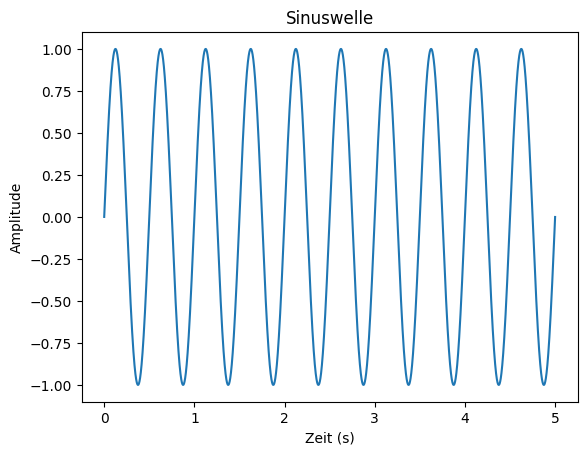

In [3]:
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)

plt.plot(x,y, 'tab:blue')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.title('Sinuswelle')
plt.show()

Die x-Achse stellt die Zeit in Sekunden dar, und da es zwei Spitzen für jede Sekunde gibt, kann man sehen, dass die Sinuswelle zweimal pro Sekunde schwingt. Diese Sinuswelle hat eine zu niedrige Frequenz, um hörbar zu sein. Im nächsten Abschnitt werden wir daher einige Sinuswellen mit höherer Frequenz erzeugen und sehen, wie Sie diese mischen können.

## Audiosignale mischen

Die gute Nachricht ist, dass das Mischen von Audiosignalen aus nur zwei Schritten besteht:

* Addieren der Signale
* Normalisieren des Ergebnisses

Zunächst erzeugen wir die Signale:

In [4]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone

Dieses Codebeispiel ist nicht neu. Es erzeugt einen Ton mit mittlerer Tonhöhe und einen Ton mit hoher Tonhöhe, die den Variablen `nice_tone` bzw. `noise_tone` zugewiesen werden. Der hohe Ton wird als unerwünschtes Rauschen verwendet und daher mit 0,3 multipliziert, um seine Leistung zu verringern. Der Code addiert dann diese Töne zusammen. Beachte, dass wir den Unterstrich (_) verwenden, um die von generate_sine_wave() zurückgegebenen x-Werte zu verwerfen.

Der nächste Schritt ist die Normalisierung bzw. Skalierung des Signals, damit es in das Zielformat passt. Aufgrund der Art und Weise, wie das Audiosignal später gespeichert wird, ist das Zielformat eine 16-Bit-Ganzzahl, die einen Bereich von -32768 bis 32767 hat:

In [5]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

Hier wird mixed_tone so skaliert, dass es genau in einen 16-Bit-Integer passt, und dann mit `np.int16` von NumPy in diesen Datentyp gecastet. Dividiert man `mixed_tone` durch seinen Maximalwert, wird es auf einen Wert zwischen -1 und 1 skaliert. Wird dieses Signal mit 32767 multipliziert, wird es zwischen -32767 und 32767 skaliert, was ungefähr dem Bereich von `np.int16` entspricht. Der Code zeichnet nur die ersten 1000 Abtastwerte auf, damit Sie die Struktur des Signals besser erkennen können.

Dein Diagramm sollte in etwa so aussehen:

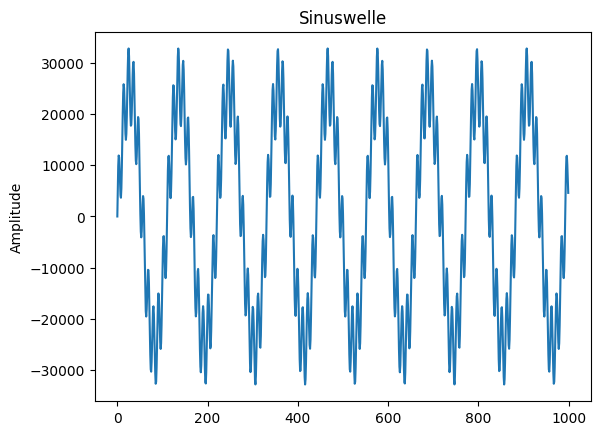

In [6]:
plt.plot(normalized_tone[:1000], 'tab:blue')
plt.ylabel('Amplitude')
plt.title('Sinuswelle')
plt.show()

Das Signal sieht aus wie eine verzerrte Sinuswelle. Die Sinuswelle ist der 400-Hz-Ton, den wir erzeugt haben, und die Verzerrung ist der 4000-Hz-Ton. Wenn man genau hinsieht, kann man erkennen, dass die Verzerrung die Form einer Sinuswelle hat.

Um den Ton anzuhören, können wir ihn in einem Format speichern, das ein Audioplayer lesen kann. Am einfachsten ist es, die Methode `wavfile.write` von `SciPy` zu verwenden, um sie in einer WAV-Datei zu speichern. 16-Bit-Ganzzahlen sind ein Standard-Datentyp für WAV-Dateien, also normalisieren Sie Ihr Signal auf 16-Bit-Ganzzahlen:

In [7]:
from scipy.io.wavfile import write
import IPython.display as ipd
# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("meinsinus.wav", SAMPLE_RATE, normalized_tone)
ipd.Audio('meinsinus.wav') # load a local WAV file

Dieser Code schreibt in eine Datei `meinsinus.wav` in dem Verzeichnis, in dem wir das Python-Skript ausführen. Danach rufen wir die Date auf, sodass wir das Audio direkt anhören können. Du wirst einen tieferen und einen höheren Ton hören. Das sind die 400-Hz- und 4000-Hz-Sinuswellen, die du gemischst hat.

Wenn du diesen Schritt abgeschlossen hast, hast du deinAudiobeispiel fertig. Der nächste Schritt ist das Entfernen des hohen Tons mithilfe der Fourier-Transformation!

## Fast Fourier-Transformation (FFT)

Die FFT ist ein Algorithmus, der die Fourier-Transformation implementiert und ein Frequenzspektrum für ein Signal im Zeitbereich, z. B. dein Audiosignal, berechnen kann:

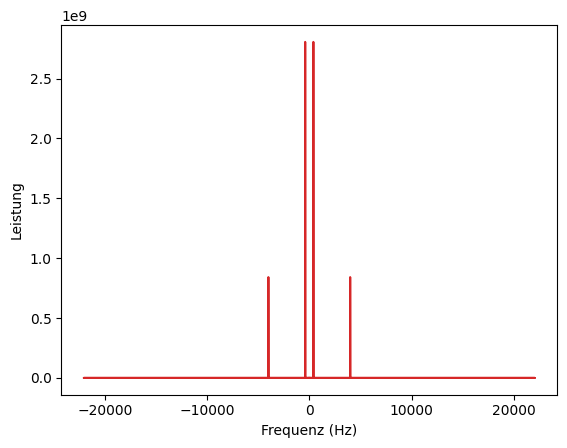

In [8]:
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

yf = fft(normalized_tone)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf), 'tab:red')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Leistung')
plt.show()

Man kann zwei Spitzen bei den positiven Frequenzen und Spiegelungen dieser Spitzen bei den negativen Frequenzen erkennen. Die Spitzen der positiven Frequenzen liegen bei 400 Hz und 4000 Hz, was den Frequenzen entspricht, die du in das Audiosignal eingegeben hast.

Die Fourier-Transformation hat Ihr kompliziertes, schwabbeliges Signal in die darin enthaltenen Frequenzen umgewandelt. Da du nur zwei Frequenzen hineingegeben hast, sind auch nur zwei Frequenzen herausgekommen. Die Negativ-Positiv-Symmetrie ist ein Nebeneffekt der Fourier-Transformation bei der Eingabe von reellen Werten, aber dazu später mehr.

In den ersten paar Zeilen importieren wir die Funktionen aus `scipy.fft`, die du später verwenden wirst, und definieren eine Variable, $N$, die die Gesamtzahl der Abtastwerte im Signal speichert.

Der Code ruft zwei wichtige Funktionen auf:

* `fft()`: berechnet die Transformation
* `fftfreq()`: berechnet die Frequenzen in der Mitte jedes Bin in der Ausgabe von `fft()`. Ohne diese Funktion gäbe es keine Möglichkeit, die x-Achse des Frequenzspektrums darzustellen.

Ein Bin ist ein Bereich von Werten, die gruppiert wurden, wie in einem Histogramm. Für die Zwecke dieses Tutorials kannst du sie dir als einzelne Werte vorstellen.

Außerdem wird `np.abs()` für `yf` aufgerufen, weil die Werte der FFT komplex sind.

```{note} 
Nebenbei bemerkt, hast du vielleicht bemerkt, dass `fft()` eine maximale Frequenz von knapp über 20 Tausend Hertz zurückgibt, 22050Hz, um genau zu sein. Dieser Wert ist genau die Hälfte unserer Abtastrate und wird als Nyquist-Frequenz bezeichnet.
Dies ist ein grundlegendes Konzept in der Signalverarbeitung und bedeutet, dass die Abtastrate mindestens das Doppelte der höchsten Frequenz des Signals betragen muss.
```

## Schnellere *fast* FT mittels `rfft()`

Das von `fft()` ausgegebene Frequenzspektrum wurde an der y-Achse gespiegelt, so dass die negative Hälfte ein Spiegelbild der positiven Hälfte war. Diese Symmetrie wurde durch die Eingabe von reellen Zahlen (nicht von komplexen Zahlen) in die Transformation verursacht.

Wir können diese Symmetrie nutzen, um unsere Fourier-Transformation schneller zu machen, indem wir nur die Hälfte davon berechnen. `scipy.fft` implementiert diesen Speed-Hack in Form von `rfft()`.

Das Tolle an `rfft()` ist, dass es ein sofortiger Ersatz für `fft()` ist. Durch das Einfügen von `rfft()` bleibt der Code größtenteils derselbe, nur mit ein paar wichtigen Änderungen:

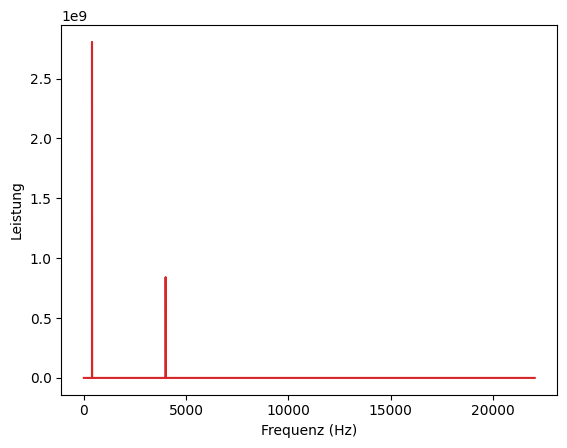

In [9]:
from scipy.fft import rfft, rfftfreq

# Note the extra 'r' at the front
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf), 'tab:red')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Leistung')
plt.show()

Da `rfft()` nur die Hälfte der Ausgabe von `fft()` liefert, wird eine andere Funktion für die Frequenzzuordnung verwendet, nämlich `rfftfreq()` anstelle von `fftfreq()`.

`rfft()` erzeugt immer noch eine komplexe Ausgabe, so dass der Code für die Darstellung des Ergebnisses derselbe bleibt.

Wie du siehst, ist das obige Bild nur die positive Seite des Frequenzspektrums, das `fft()` erzeugt. `rfft()` berechnet nie die negative Hälfte des Frequenzspektrums, was es schneller macht.
Sie kann bis zu doppelt so schnell sein, aber einige Eingabelängen sind schneller als andere. Wenn du weißt, dass du nur mit reellen Zahlen arbeiten wirst, dann ist das ein Geschwindigkeits-Hack, den du kennen solltest.

Jetzt, da du das Frequenzspektrum des Signals hast, kannst du mit der Filterung fortfahren.

## Filtern des Signals

Ein großer Vorteil der Fourier-Transformation ist, dass sie umkehrbar ist. Das bedeutet, dass alle Änderungen, die du am Signal im Frequenzbereich vornimmst, auch bei der Rücktransformation in den Zeitbereich gelten. Das kannst du dir zunutze machen, um dein Audiosignal zu filtern und die hohen Frequenzen loszuwerden.

:::{warning} 
Die in diesem Abschnitt gezeigte Filtertechnik ist für reale Signale nicht geeignet. Es wird ein weiteres Tutorial erstellt, wo digitale Signalverarbeitung und Filtertechniken eingeführt werden.
:::

Die von `rfft()` zurückgegebenen Werte stellen die Leistung der einzelnen Frequenzbereiche dar. Wenn wir die Leistung eines bestimmten Bins auf Null setzen, werden die Frequenzen in diesem Bin im resultierenden Zeitsignal nicht mehr vorhanden sein.

Anhand der Länge von `xf`, der maximalen Frequenz und der Tatsache, dass die Frequenzbins gleichmäßig verteilt sind, kann der Index der Zielfrequenz berechnet werden:

In [10]:
# The maximum frequency is half the sample rate
points_per_freq = len(xf) / (SAMPLE_RATE / 2)

# Our target frequency is 4000 Hz
target_idx = int(points_per_freq * 4000)

Du kannst im folgenden Code `yf` bei Indizes um die Zielfrequenz herum auf 0 setzen, um sie loszuwerden:

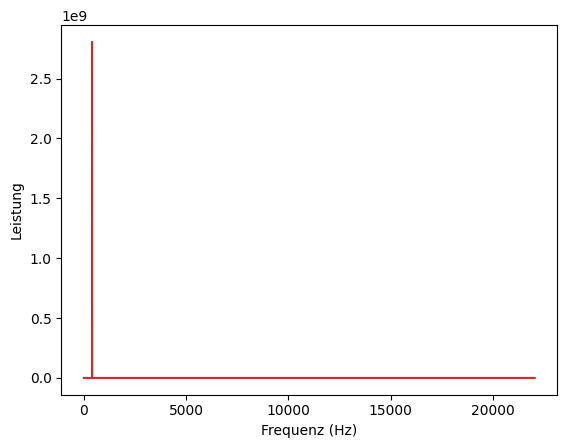

In [11]:
yf[target_idx - 1 : target_idx + 2] = 0
plt.plot(xf, np.abs(yf), 'tab:red')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Leistung')
plt.show()

Da es nur eine Spitze gibt, sieht es so aus, als hätte es funktioniert! 

## Die inverse FFT anwenden

Als nächstes wenden wir die inverse Fourier-Transformation an, um in den Zeitbereich zurückzukehren. Da du `rfft()` verwendest, musst du `irfft()` verwenden, um die Umkehrung anzuwenden. Hätten wir `fft()` verwendet, dann wäre die inverse Funktion `ifft()` gewesen. 

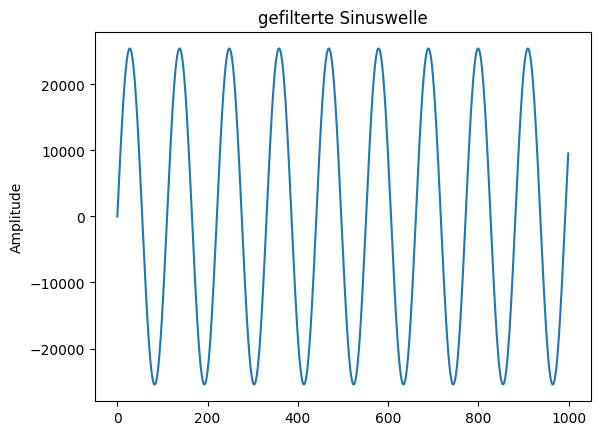

In [12]:
from scipy.fft import irfft

new_sig = irfft(yf)
plt.plot(new_sig[:1000], 'tab:blue')
plt.ylabel('Amplitude')
plt.title('gefilterte Sinuswelle')
plt.show()

Wie du siehst, hast du jetzt eine einzelne Sinuswelle, die mit 400 Hz schwingt, und du hast das 4000-Hz-Rauschen erfolgreich entfernt.

Noch einmal musst du das Signal normalisieren, bevor du es in eine Datei schreibst:

In [13]:
import IPython.display as ipd
norm_new_sig = np.int16(new_sig * (32767 / new_sig.max()))
write("clean.wav", SAMPLE_RATE, norm_new_sig)
ipd.Audio('clean.wav') # load a local WAV file